In [3]:
from env import Enviroment
from evolved_agent import EvolvedAgent
from actors import Agent, Wall, Landmark
from typing import List
import numpy as np
from copy import deepcopy
from math import degrees, atan2, pi
from utils import distance_from_wall, intersection, angle_from_vector, intersection_line_circle
import torch
from nn import NN
from parameters import *
import matplotlib.pyplot as plt
from numpy import ceil
import pygame
import math
import matplotlib.animation as animation

CLIP = 50
GRID_SIZE = 10

class EnvEvolution(Enviroment):
    def __init__(
        self,
        agent: EvolvedAgent,
        walls: List[Wall] = [],
        landmarks: List[Landmark] = [],
        height=800,
        width=800,
        instants=1000,
        w1=1,
        w2=1,
        w3=0.2,
        
    ):
        super().__init__(agent, walls, landmarks)
        self.height = height
        self.width = width
        self.map = np.zeros((self.width, self.height))
        self.collisions = 0
        self.movements = 0
        self.instants = instants
        self.W1 = w1
        self.W2 = w2
        self.W3 = w3
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []
        self.map = np.zeros((self.width, self.height))
        self.w = []

    def reset(self, random=False):
        if random:
            self.agent.pos = np.array(
                [np.random.randint(0, self.width), np.random.randint(0, self.height)],
                dtype=np.float64,
            )
            self.agent.direction_vector = np.array(
                [np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype=np.float64
            )
        else:
            self.agent.pos = np.array([self.width // 2, self.height // 2], dtype=np.float64)
        self.collisions = 0
        self.movements = 0
        self.map = np.zeros((self.width, self.height))
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []
        

    def move_agent(self, dt=1):
        try:
            distances = np.array([data[1][0] for data in self.get_sensor_data(self.agent.n_sensors, self.agent.max_distance)], dtype=np.float32)
            vl, vr = self.agent.controller.forward(torch.tensor(distances, dtype=torch.float))
        except Exception as e:
            print(e)
            vl, vr = 0, 0
        vl = vl *10
        vr = vr *10
        v, w = (vl + vr) / 2, (vr - vl) / (self.agent.size * 2) 
        if w == v == 0:
            return
        print("vl, vr, v, w", vl, vr, v, w)
        if distances[0] > self.agent.size * 2:
            w = 0
            if 0 < v < 1:
                v = 1
            elif -1 < v < 0:
                v = -1
            elif v > 1:
                v *= 10
            elif v < -1:
                v *= 10
                
        if distances[0] < self.agent.size * 2:
            v = 0
            w *= 10
        dx,dy, dtheta = 0,0, w * dt
        if w == 0:
            dx = v * dt * np.cos(self.agent.direction)
            dy = v * dt * np.sin(self.agent.direction)
        else:
            R = v / w
            dx = R * (np.sin(self.agent.direction + dtheta) - np.sin(self.agent.direction))
            dy = -R * (np.cos(self.agent.direction + dtheta) - np.cos(self.agent.direction))

        dx, dy = round(dx), round(dy)
        move_vector = np.array([dx, dy])
        
        for wall in self.walls:
            current_d = distance_from_wall(wall, self.agent.pos)

            if current_d <= self.agent.size:
                # Vector of the wall direction
                wall_vector = np.array(
                    [wall.end[0] - wall.start[0], wall.end[1] - wall.start[1]]
                )
                wall_vector = wall_vector / np.linalg.norm(wall_vector)

                # Vector of the agent parallel to the wall
                parallel_component = np.dot(wall_vector, move_vector) * wall_vector

                # Vector of the agent perpendicular to the wall
                wall_to_agent = self.agent.pos - np.array(
                    distance_from_wall(wall, self.agent.pos, coords=True)
                )
                wall_to_agent = wall_to_agent / np.linalg.norm(wall_to_agent)

                # If the agent is inside the wall push it out
                self.agent.apply_vector(wall_to_agent * (self.agent.size - current_d))
                # Check if the agent is moving towards the wall
                if np.dot(self.agent.direction_vector, -wall_to_agent) > 0:
                    # If the agent is moving towards the wall only consider the parallel component
                    move_vector = parallel_component

        # Check if the agent is making an illegal move
        for wall in self.walls:
            intersection_point = intersection(
                Wall(
                    self.agent.pos[0],
                    self.agent.pos[1],
                    self.agent.pos[0] + move_vector[0],
                    self.agent.pos[1] + move_vector[1],
                ),
                wall,
            )
            if intersection_point:
                # print("ILLEGAL MOVE")
                return
        self.agent.apply_vector(move_vector)

        # Aggiorna il percorso
        self.path.append((self.agent.pos[0], self.agent.pos[1]))
        
        # Set visited positions to 1 within -10 to +10 range around agent's position
        x_start = max(0, int(x_start) - 10)
        x_end = min(self.map.shape[0], int(self.agent.pos[0]) + 10 + 1)
        y_start = max(0, int(y_start) - 10)
        y_end = min(self.map.shape[1], int(self.agent.pos[1]) + 10 + 1)

        # Efficiently set the range using numpy slicing
        if x_start > x_end:
            x_start, x_end = x_end, x_start
        if y_start > y_end:
            y_start, y_end = y_end, y_start
        self.map[x_start:x_end, y_start:y_end] = 1
        
        
        

        # Ruota l'agente
        self.agent.rotate(dtheta)


    def fitness_score(self) -> float:
        #mean_angular_velocity = np.mean(np.abs(self.w))
        #print(f"Mean Angular Velocity: {mean_angular_velocity}")
        if self.collisions == 0:
            return self.explored_terrain #- mean_angular_velocity
        return self.explored_terrain #+ 1 / self.collisions - mean_angular_velocity
    @property
    def explored_terrain(self) -> float:
        return np.sum(self.map) / (self.width * self.height)

    def visualize_movement(self):
            if not self.path:
                return

            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(self.map.T, origin='lower', cmap='gray_r')
            
            # Correct the point size for the agent
            ax.scatter(self.agent.pos[0], self.agent.pos[1], color='green', s=(self.agent.size * 2)**2, label='Agent')
            
            for wall in self.walls:
                ax.plot([wall.start[0], wall.end[0]], [wall.start[1], wall.end[1]], 'b-', linewidth=2)
            
            # Plot the path
            path = np.array(self.path)
            ax.plot(path[:, 0], path[:, 1], 'r-', label='Path')
            
            ax.set_title('Agent Movement and Explored Terrain')
            ax.set_xlabel('Width')
            ax.set_ylabel('Height')
            ax.legend()
            plt.show()

vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5

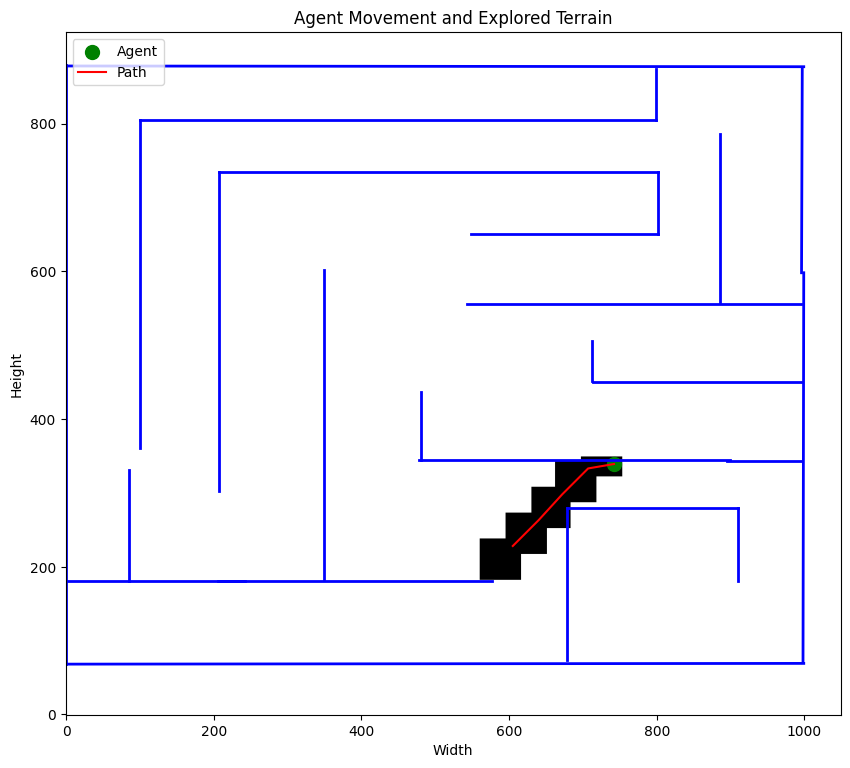

final pos [742. 339.] initial pos [570. 193.]  collisions 2 explored terrain 0.01894375 fitness 0.01894375
vl, vr, v, w 7.835817933082581 2.164182662963867 5.000000298023224 -0.5671635270118713
vl, vr, v, w 9.997926354408264 0.0020737371232826263 5.000000045765773 -0.9995852617284982
vl, vr, v, w 9.951506853103638 0.04849306307733059 4.999999958090484 -0.9903013790026307
vl, vr, v, w 8.018988966941833 1.9810114800930023 5.000000223517418 -0.6037977486848831
vl, vr, v, w 9.805123805999756 0.19487587735056877 4.999999841675162 -0.9610247928649187
vl, vr, v, w 9.733238220214844 0.2667614817619324 4.999999850988388 -0.9466476738452911
vl, vr, v, w 9.828327298164368 0.1716732606291771 5.000000279396772 -0.9656654037535191
vl, vr, v, w 7.961705923080444 2.0382940769195557 5.0 -0.5923411846160889
vl, vr, v, w 9.988415837287903 0.011584957828745246 5.000000397558324 -0.9976830879459158
vl, vr, v, w 9.997208714485168 0.0027907147887162864 4.999999714636942 -0.9994417999696452
vl, vr, v, w 9.883

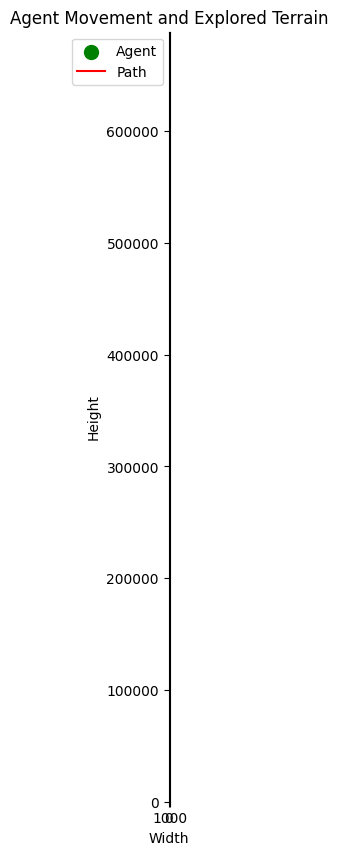

final pos [6.00000e+00 6.56218e+05] initial pos [114. 502.]  collisions 14921 explored terrain 0.0786015625 fitness 0.0786015625
vl, vr, v, w 5.633727312088013 4.366271793842316 4.999999552965164 -0.1267455518245697
vl, vr, v, w 5.53029477596283 4.469704627990723 4.999999701976776 -0.1060590147972107
vl, vr, v, w 0.8103789389133453 9.189621210098267 5.000000074505806 0.8379242271184921
vl, vr, v, w 5.53029477596283 4.469704627990723 4.999999701976776 -0.1060590147972107
vl, vr, v, w 4.682749509811401 5.317250490188599 5.0 0.06345009803771973
vl, vr, v, w 0.04096202086657286 9.959037899971008 4.999999960418791 0.9918075879104435
vl, vr, v, w 5.53029477596283 4.469704627990723 4.999999701976776 -0.1060590147972107
vl, vr, v, w 5.707146525382996 4.2928531765937805 4.999999850988388 -0.1414293348789215
vl, vr, v, w 2.304258793592453 7.695741057395935 4.999999925494194 0.5391482263803482
vl, vr, v, w 1.4204846322536469 8.579515218734741 4.999999925494194 0.7159030586481094
vl, vr, v, w 2.01

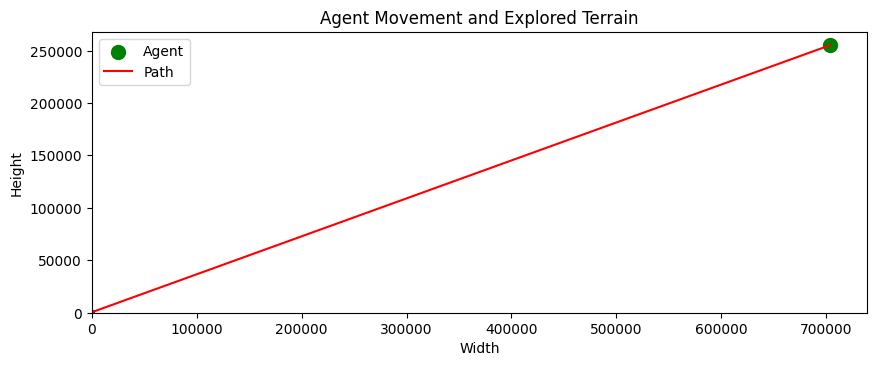

final pos [703837. 255085.] initial pos [153. 307.]  collisions 29 explored terrain 0.0393953125 fitness 0.0393953125
vl, vr, v, w 0.006972279516048729 9.993027448654175 4.999999864085112 0.9986055169138126
vl, vr, v, w 0.001560137461638078 9.99843955039978 4.999999843930709 0.9996879412938142
vl, vr, v, w 0.0035454111639410257 9.99645471572876 5.00000006344635 0.9992909304564819
vl, vr, v, w 0.09761500172317028 9.902384281158447 4.999999641440809 0.9804769279435277
vl, vr, v, w 0.023470313753932714 9.976529479026794 4.999999896390364 0.9953059165272862
vl, vr, v, w 0.0003574903166736476 9.999642372131348 4.999999931224011 0.9999284881814674
vl, vr, v, w 5.717130989069119e-05 9.999942779541016 4.999999975425453 0.9999885608231125
vl, vr, v, w 0.003649252757895738 9.99635100364685 5.000000128202373 0.9992701750888955
vl, vr, v, w 0.0020073029736522585 9.997993111610413 5.000000207292032 0.999598580863676
vl, vr, v, w 0.0011753213038900867 9.99882459640503 4.99999995885446 0.999764927510

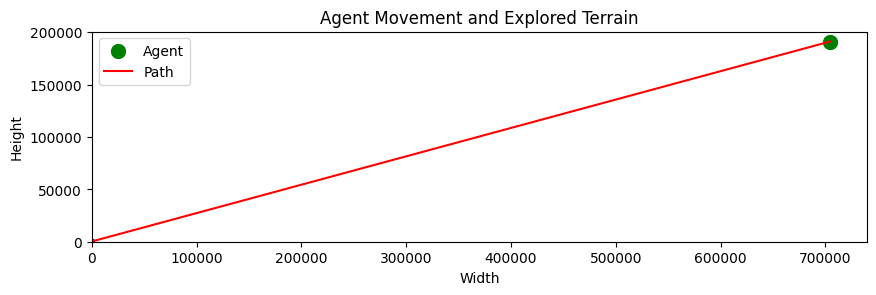

final pos [704455. 191051.] initial pos [292. 628.]  collisions 106 explored terrain 0.259321875 fitness 0.259321875
vl, vr, v, w 0.0032934104092419147 9.996706247329712 4.999999828869477 0.999341283692047
vl, vr, v, w 0.07970812730491161 9.920291900634766 5.000000013969839 0.9840583773329854
vl, vr, v, w 0.5890883132815361 9.410911798477173 5.0000000558793545 0.8821823485195637
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v

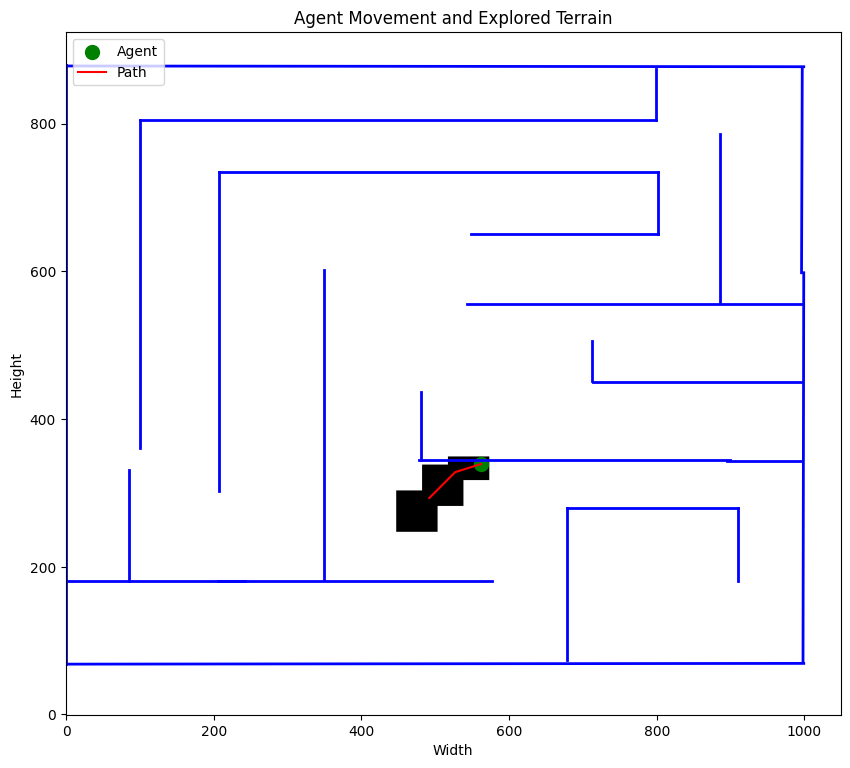

final pos [562. 339.] initial pos [457. 258.]  collisions 1 explored terrain 0.011221875 fitness 0.011221875
vl, vr, v, w 9.926244616508484 0.0737555930390954 5.00000010477379 -0.9852489023469388
vl, vr, v, w 9.91054117679596 0.08945929817855358 5.0000002374872565 -0.9821081878617406
vl, vr, v, w 9.999995231628418 4.657148053865967e-06 4.999999944388236 -0.9999990574480364
vl, vr, v, w 9.999995231628418 5.071013333690644e-06 5.000000151320876 -0.9999990160615084
vl, vr, v, w 9.998478889465332 0.0015213729056995362 5.000000131185516 -0.9996957516559632
vl, vr, v, w 8.326390981674194 1.6736096143722534 5.000000298023224 -0.6652781367301941
vl, vr, v, w 5.572024583816528 4.427975416183472 5.0 -0.11440491676330566
vl, vr, v, w 2.4476858973503113 7.552313804626465 4.999999850988388 0.5104627907276154
vl, vr, v, w 0.9296801686286926 9.070319533348083 4.999999850988388 0.8140639364719391
vl, vr, v, w 7.767539024353027 2.2324615716934204 5.000000298023224 -0.5535077452659607
vl, vr, v, w 8.372

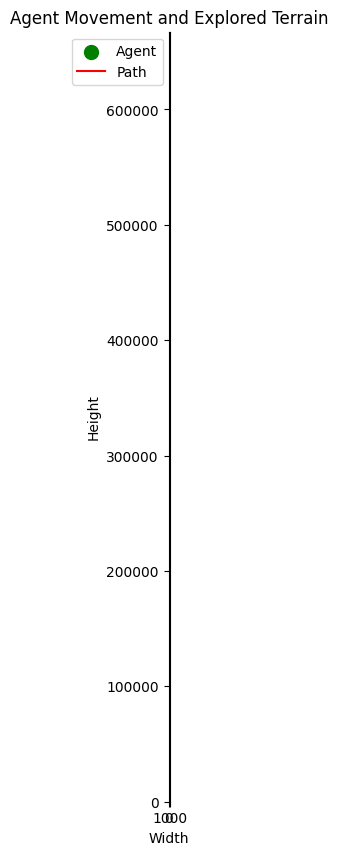

final pos [6.0000e+00 6.3556e+05] initial pos [337. 349.]  collisions 14875 explored terrain 0.122915625 fitness 0.122915625
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, v

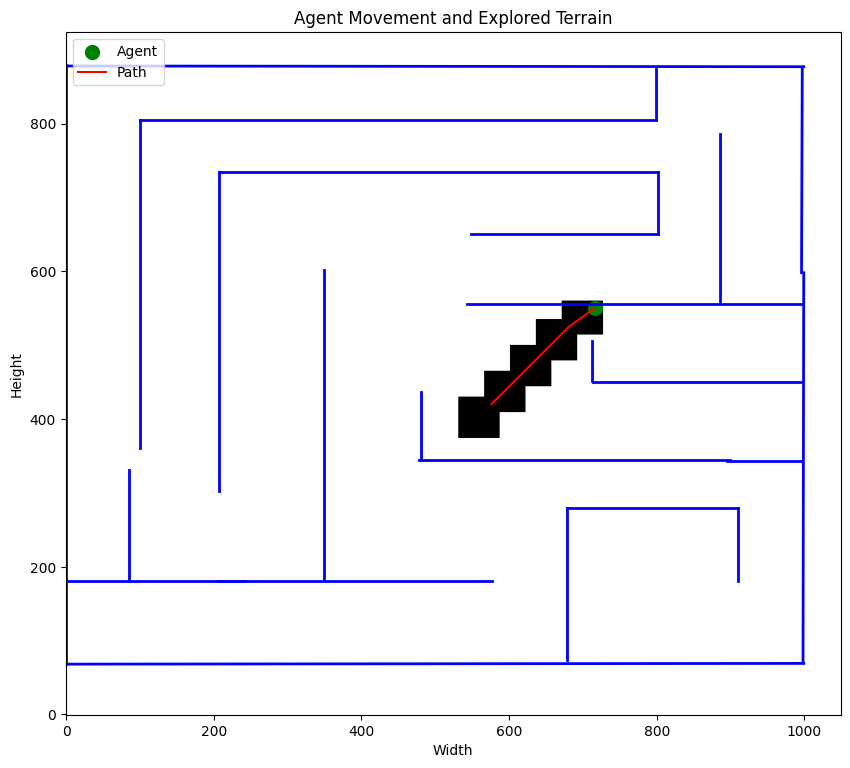

final pos [716. 550.] initial pos [541. 385.]  collisions 1 explored terrain 0.02086875 fitness 0.02086875
vl, vr, v, w 0.670693889260292 9.329306483268738 5.000000186264515 0.8658612594008446
vl, vr, v, w 1.7228108644485474 8.277188539505005 4.999999701976776 0.6554377675056458
vl, vr, v, w 2.846871316432953 7.153128981590271 5.000000149011612 0.4306257665157318
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 0.41732463985681534 9.582675695419312 5.000000167638063 0.9165351055562496
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 5.0 5.0 5.0 0.0
vl, vr, v, w 2.303188145160675 7.696811556816101 4.999999850988388 0.5393623411655426
vl, vr, v, w 0.02304416848346591 9.97695505619049 4.999999612336978 0.9953910887707025
vl, vr, v, w 0.043549719266593456 9.956450462341309 5.000000090803951 0.9912900743074715
vl, vr, v, w 0.02636401681229472 9.973636269569397 5.000000143190846 0.9947272252757102
vl, vr, v, w 0.1295334193855524 9.870467185974121 5

In [4]:
for simulation in range(10000):    
    x,y = float(np.random.randint(100, 600)), float(np.random.randint(100, 850))
    env = EnvEvolution(
        EvolvedAgent(x=x, y=y, controller=NN(), n_sensors=12, max_distance=200,size=AGENT_SIZE),
        instants=10000,
        w1=1,
        w2=1,
        w3=0.2,
    )
    env.agent.rotate(pi/4)
    #env.agent.controller.load_state_dict(torch.load("./saves/best_last_agent.pth"))
    env.load_walls(WALLS_TXT)
    initial_pos = env.agent.pos.copy()
    for step in range(15000):
        if step == 100 and env.explored_terrain < 0.01:
            break
        env.move_agent()
        
        
    if env.explored_terrain < 0.01:
        continue
    env.visualize_movement()
    print("final pos", env.agent.pos, "initial pos", initial_pos, " collisions", env.collisions, "explored terrain", env.explored_terrain, "fitness", env.fitness_score())
 